In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load users data
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
engagement=pd.read_csv('takehome_user_engagement.csv',encoding='latin-1')

In [3]:
print(users.shape)
users.head()

(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
sns.set()
print(engagement.shape)
engagement.head()

(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
# lets examine the user data to see who is actually using the application
print('There are {} users who have ever used the application.'\
          .format(len(list(engagement['user_id'].unique()))))
print('There are {} signed up for the application.'\
          .format(len(list(users['object_id'].unique()))))

print('There is a discrepancy of {} users.'\
          .format(int(len(list(users['object_id'].unique()))) 
                  - int(len(list(engagement['user_id'].unique())))))

There are 8823 users who have ever used the application.
There are 12000 signed up for the application.
There is a discrepancy of 3177 users.


In [6]:
# how many people never signed in?
print('There are ', len(users[users['last_session_creation_time'].isnull()]), 'inactive users.')

There are  3177 inactive users.


# Inference 
1. From engagement dataframe, we can determine if a user is "adopted" the app.
2. From Users dataframe, we can evaluate the Best features which determines the users "Adopted" 

For doing this we have to undertand the data in itself by doing Descriptive analytics and deal with any missing, duplicate, and/or irrelevant data points.

As outlined, in this case an adopted user is any ID that had logged in on at least 3 serarate occasions in a 7 day period.

# Data Wrangling & EDA

In [7]:
# Check for missing data in each of the supplied data sets
print('user_engagement')
print(engagement.isnull().any())
print("\n")
print('user_engagement')
print(users.isnull().any())

user_engagement
time_stamp    False
user_id       False
visited       False
dtype: bool


user_engagement
object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time     True
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
dtype: bool


In [8]:
# How much missing data do we have e.g. if we drop it how much info is gone?
print(users['last_session_creation_time'].isnull().value_counts())
print(users['invited_by_user_id'].isnull().value_counts())

False    8823
True     3177
Name: last_session_creation_time, dtype: int64
False    6417
True     5583
Name: invited_by_user_id, dtype: int64


Significant number of rows are missing these values in these 2 columns

In [9]:
# Time stamp is not in valid data type, it needs to be changed
print(engagement.dtypes)
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
print('\n',engagement.dtypes)

time_stamp    object
user_id        int64
visited        int64
dtype: object

 time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object


# Create Active User Function
Apply this function to the dataset to create the 'adopted_user' labels, where an adopted user represents people who logged in at least 3 times within a 7 day period.

In [10]:
# time to add in the adopted user feature so that we can categorize the data

def adopted_user(engagement):
    seven_days = datetime.timedelta(7)
    adopted_dict = {}

    for user_id in sorted(list(engagement['user_id'].unique())):
    
        adopted_user = 0
        temp = engagement[engagement['user_id'] == user_id]
        temp = temp.sort_values('time_stamp')
    
        for row in temp.itertuples():
            if adopted_user == 1:
                continue
            this_time = temp.get_value(row[0], 'time_stamp')
            if len(temp[(temp['time_stamp'] >= this_time) & (temp['time_stamp'] <= (this_time + seven_days))]) >= 3:
                adopted_user = 1
        
        adopted_dict[user_id] = adopted_user
    return adopted_dict

In [11]:
dict_active = adopted_user(engagement)
active_df = pd.DataFrame(dict_active.items(), columns=['user_id', 'active'])
active_df.head()

,user_id,active
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


Less than 19% of users are active and rest are inactive ot they haven't even registered.

In [12]:
active_df.active.value_counts(1)

0    0.812309
1    0.187691
Name: active, dtype: float64

In [13]:
adopted_user = active_df[active_df['active']==1].user_id.values
adopted_user

array([    2,    10,    20, ..., 11969, 11975, 11988], dtype=int64)

# Create "adopted_user" label

In [14]:
users['adopted_user'] = users.object_id.isin(adopted_user)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In the Users file, we have only 14% users as active

In [15]:
users.adopted_user.value_counts(1)

False    0.862
True     0.138
Name: adopted_user, dtype: float64

In [16]:
# Convert the boolean label into an int
users.adopted_user = users.adopted_user.astype(int)

In [111]:
# Add days from creation to last login feature
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')
users['days_since_signup'] = (users.last_session_creation_time - users.creation_time).apply(lambda x: x.days)
users.days_since_signup.fillna(0, inplace=True)

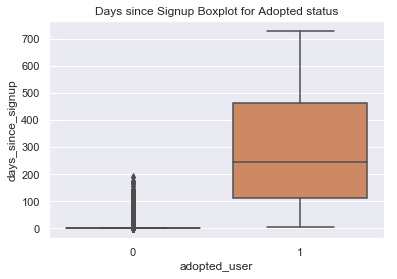

In [115]:
plt.title('Days since Signup Boxplot for Adopted status')
sns.boxplot(y='days_since_signup', x='adopted_user', data=users)

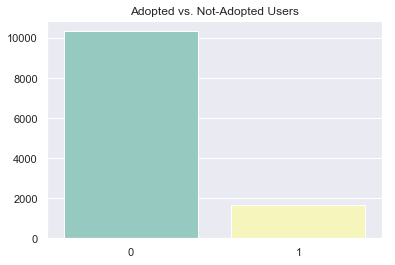

In [53]:
# Take another look at the distribution of the target class
sns.barplot(x = list(users['adopted_user'].value_counts().index), y = users['adopted_user'].value_counts(), palette="Set3")
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users');


# Explore Creation Source
**Summary:** 

- Majority of the users were invited to an organization as a full member
- Doesn't seem to have any difference between adopted users and non-adopted users

In [19]:
users.creation_source.value_counts(1)

ORG_INVITE            0.354500
GUEST_INVITE          0.180250
PERSONAL_PROJECTS     0.175917
SIGNUP                0.173917
SIGNUP_GOOGLE_AUTH    0.115417
Name: creation_source, dtype: float64

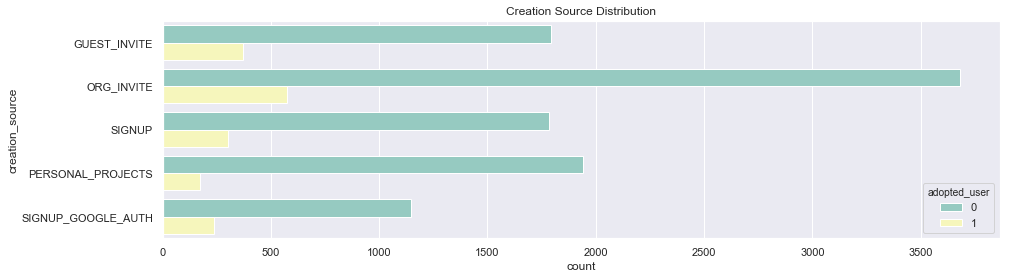

In [52]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="creation_source", hue='adopted_user', data=users,palette="Set3").set_title('Creation Source Distribution');

# Explore Marketing Drip

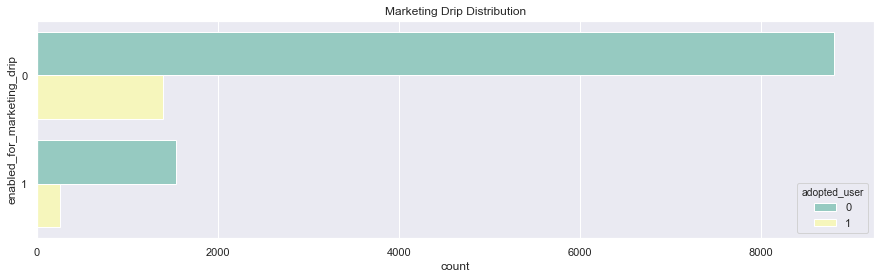

In [51]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="enabled_for_marketing_drip", hue='adopted_user', data=users,palette="Set3").set_title('Marketing Drip Distribution');

# Explore Mailing List Opt

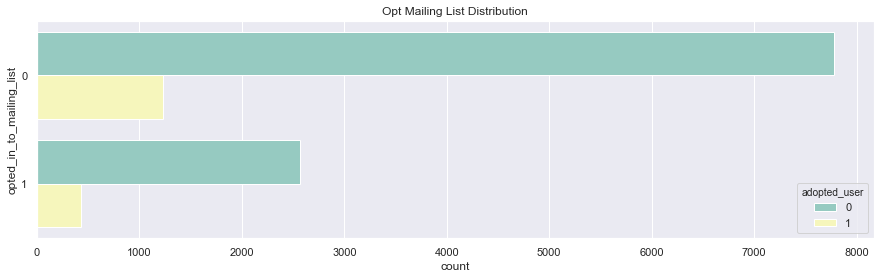

In [54]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="opted_in_to_mailing_list", hue='adopted_user', data=users,palette="Set3").set_title('Opt Mailing List Distribution');

# Create new features (Month and Year)

In [25]:
users['creation_time'] = pd.to_datetime(users.creation_time)

In [27]:
users['year'] = users['creation_time'].dt.year
users['month'] = users['creation_time'].dt.month
users['day'] = users['creation_time'].dt.day

In [28]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,year,month,day
0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,2014,4,22
1,2,2013-11-15 03:45:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,2013,11,15
2,3,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,2013,3,19
3,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,2013,5,21
4,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,2013,1,17


[]

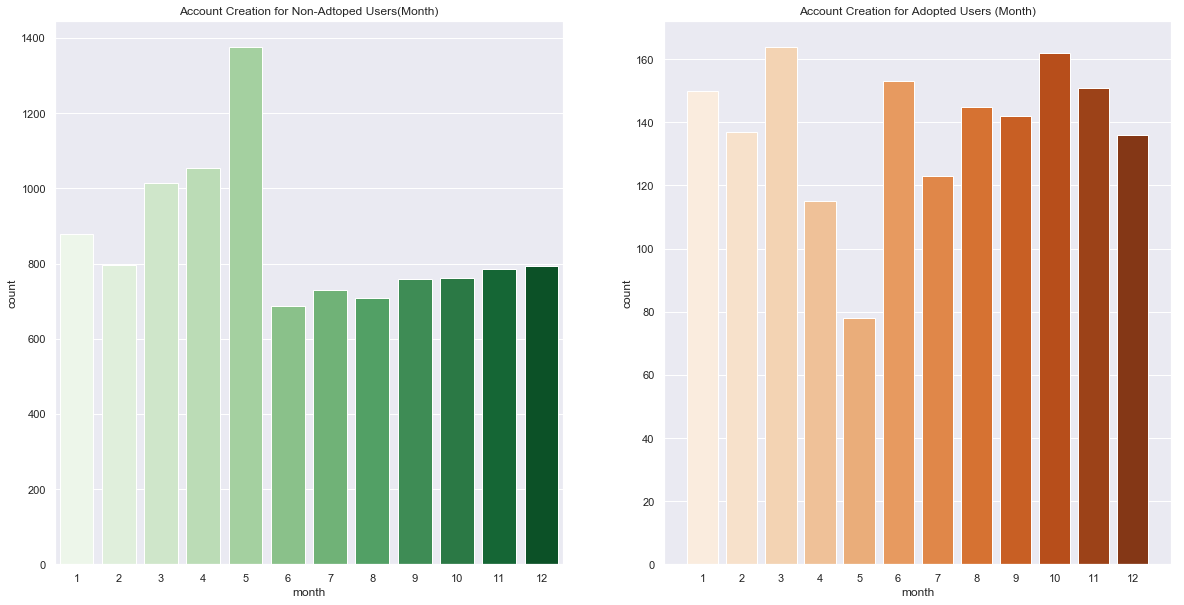

In [57]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
sns.countplot(x='month', data=users[users['adopted_user']==0],palette="Greens").set_title('Account Creation for Non-Adtoped Users(Month)');

plt.subplot(1, 2, 2)
sns.countplot(x='month', data=users[users['adopted_user']==1],palette='Oranges').set_title('Account Creation for Adopted Users (Month)');

plt.plot()

In [117]:
df = users.copy()

last_created_mode = df.last_session_creation_time.mode()[0]

# Fill NaN values
df['invited_by_user_id'].fillna(0, inplace=True)
df.loc[df['invited_by_user_id'].notnull(), 'invited_by_user_id'] = 1

df['last_session_creation_time'].fillna(last_created_mode, inplace=True)

# Email address converted to just hosted address
df['email'] = df['email'].str.split('@').str[1]

# Drop name column
df.drop('name', axis=1, inplace=True)

# Change org column to categorical
df['org_id'] = df['org_id'].astype('category')
df.head()

,object_id,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,year,month,day,days_since_signup
0,1,2014-04-22 03:53:00,yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1.0,0,2014,4,22,0.0
1,2,2013-11-15 03:45:00,gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1.0,1,2013,11,15,136.0
2,3,2013-03-19 23:14:00,gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1.0,0,2013,3,19,0.0
3,4,2013-05-21 08:09:00,yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1.0,0,2013,5,21,1.0
4,5,2013-01-17 10:14:00,yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1.0,0,2013,1,17,5.0


In [118]:
main_org  = df.org_id.value_counts().head(10).index.tolist()
main_org

[0, 1, 2, 3, 4, 6, 5, 9, 7, 10]

In [119]:
df.org_id = ['major' if org_id in main_org  else 'minor' for org_id in df.org_id]

In [120]:
df.head()

,object_id,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,year,month,day,days_since_signup
0,1,2014-04-22 03:53:00,yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,minor,1.0,0,2014,4,22,0.0
1,2,2013-11-15 03:45:00,gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,major,1.0,1,2013,11,15,136.0
2,3,2013-03-19 23:14:00,gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,minor,1.0,0,2013,3,19,0.0
3,4,2013-05-21 08:09:00,yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,major,1.0,0,2013,5,21,1.0
4,5,2013-01-17 10:14:00,yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,minor,1.0,0,2013,1,17,5.0


Text(0.5, 1.0, 'Adopted Status by Organization')

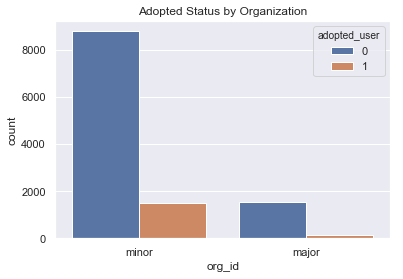

In [121]:
sns.countplot(x='org_id', hue='adopted_user', data=df)
plt.title('Adopted Status by Organization')

# Feature Analysis and Model Creation

In [127]:
email = pd.get_dummies(df.email, drop_first=True)
creation_source = pd.get_dummies(df.creation_source, drop_first=True)
org_id = pd.get_dummies(df.org_id, drop_first=True)
adopted = df.adopted_user.astype(int)

opted_in_to_mailing_list = df.opted_in_to_mailing_list
enabled_for_marketing_drip = df.enabled_for_marketing_drip
days_since_signup = df.days_since_signup

In [129]:
data_df = pd.concat([email, creation_source, opted_in_to_mailing_list, enabled_for_marketing_drip, 
                     org_id, days_since_signup, adopted], axis=1)
data_df.head()

,adpql.com,aerbd.com,aethf.com,afzjt.com,agfei.com,aiouj.com,aipbl.com,ajrkw.com,akwfl.com,aldgv.com,...,zwmry.com,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list,enabled_for_marketing_drip,minor,days_since_signup,adopted_user
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0.0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,136.0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0.0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,5.0,0


In [131]:
# Split data
X = np.array(data_df.drop('adopted_user', axis=1))
y = np.array(data_df.adopted_user)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [132]:
# Normalize data
scaler = StandardScaler()
scaler.fit(X_train) # use train data to fit
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [133]:
# Use gridsearch to tune parameters for logistic regression
model = LogisticRegression(class_weight='balanced')
parameters = {'C':[0.001, 0.01, 0.1], 'tol':[1e-5, 1e-4, 0.001]}
clf = GridSearchCV(model, parameters, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)
clf.best_params_, clf.cv_results_['params'], clf.cv_results_['mean_test_score']

({'C': 0.01, 'tol': 1e-05},
 [{'C': 0.001, 'tol': 1e-05},
  {'C': 0.001, 'tol': 0.0001},
  {'C': 0.001, 'tol': 0.001},
  {'C': 0.01, 'tol': 1e-05},
  {'C': 0.01, 'tol': 0.0001},
  {'C': 0.01, 'tol': 0.001},
  {'C': 0.1, 'tol': 1e-05},
  {'C': 0.1, 'tol': 0.0001},
  {'C': 0.1, 'tol': 0.001}],
 array([0.97      , 0.97      , 0.97      , 0.97239583, 0.97239583,
        0.97239583, 0.96979167, 0.96979167, 0.96979167]))

In [134]:
model = LogisticRegression(C=0.01, class_weight='balanced')
model.fit(X_train, y_train)
print(classification_report(y_true=y_test, y_pred=model.predict(X_test), target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.98      0.99      0.98      2062
         yes       0.94      0.85      0.89       338

   micro avg       0.97      0.97      0.97      2400
   macro avg       0.96      0.92      0.94      2400
weighted avg       0.97      0.97      0.97      2400



In [138]:
# Present features sorted by their corresponding coefficients
features = pd.DataFrame(data_df.columns[:-1], columns=['features'])
coefficients = pd.DataFrame(abs(model.coef_)).unstack().unstack()
results = pd.concat([features, coefficients], axis=1)
results.columns = ['features', 'coefficients']
results.sort_values(by='coefficients', ascending=False)[:5]

,features,coefficients
1190,days_since_signup,3.231085
292,gmail.com,0.151062
1189,minor,0.140402
1184,PERSONAL_PROJECTS,0.134944
338,hotmail.com,0.078055


# Findings & Conclusion
In order to perform EDA on this dataset, I had to create a function that allows you to create labels for defining an 'adopted_user'.

Based on the plots from data exploration and feature vs. coefficients table from logistic regression, five most important factors in predicting future user adoption are:

- Adopted Users accounted for 14% of the dataset
- The number of days between user's creation time and last login time
- Whether the user is from an organization with top 10 popultion size
- Whether the user's creation source is invited to join another user's personal workspace
- Whether the user registers using a gmail email address

We have also noted that the least amount of registration occurred on May for adopted users, but it's the most registered in non-adopted users.
Further Investigation: It would be great if we can have more data about user activity. One EDA that I would like to perform more on is the difference betweeen registrations of adopted vs non-adopted users during the month of May.